In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [10]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>LSTM1-CNN1</h1>

In [11]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           24640     
                                                                 
 dropout_1 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                        

In [12]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 8s 27ms/step - loss: 0.7499 - accuracy: 0.7107 - val_loss: 0.4469 - val_accuracy: 0.8685
Epoch 2/100
58/58 [==============================] - 1s 13ms/step - loss: 0.2504 - accuracy: 0.9098 - val_loss: 0.1996 - val_accuracy: 0.9270
Epoch 3/100
58/58 [==============================] - 1s 13ms/step - loss: 0.1470 - accuracy: 0.9395 - val_loss: 0.1605 - val_accuracy: 0.9320
Epoch 4/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1296 - accuracy: 0.9445 - val_loss: 0.1450 - val_accuracy: 0.9415
Epoch 5/100
58/58 [==============================] - 1s 13ms/step - loss: 0.1294 - accuracy: 0.9446 - val_loss: 0.1378 - val_accuracy: 0.9402
Epoch 6/100
58/58 [==============================] - 1s 13ms/step - loss: 0.1154 - accuracy: 0.9510 - val_loss: 0.1145 - val_accuracy: 0.9592
Epoch 7/100
58/58 [==============================] - 1s 16ms/step - loss: 0.1117 - accuracy: 0.9495 - val_loss: 0.1221 - val_accuracy: 0.9601
Epoch 

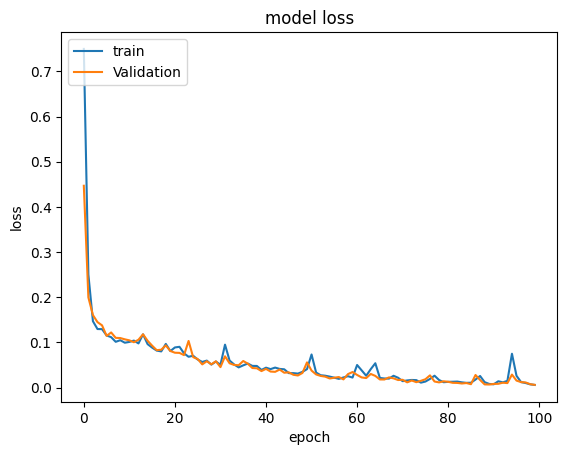

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

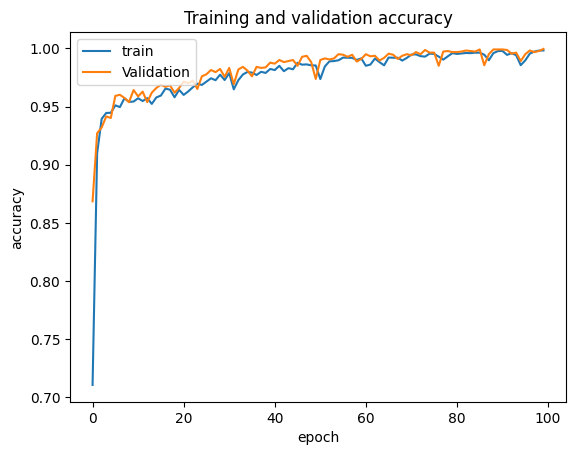

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 4ms/step
[[479   1  15   1   0   0]
 [  6 441  24   0   0   0]
 [  3   0 417   0   0   0]
 [  0   3   0 421  61   6]
 [  1   1   0  33 497   0]
 [  0   0   0   0   0 537]]
0.9474041398031897
0.9472252249134202
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       496
           1       0.99      0.94      0.96       471
           2       0.91      0.99      0.95       420
           3       0.93      0.86      0.89       491
           4       0.89      0.93      0.91       532
           5       0.99      1.00      0.99       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

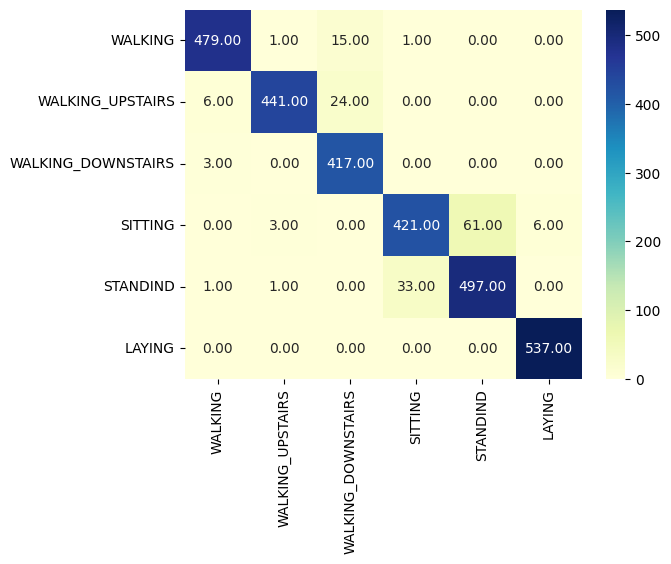

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM1-CNN 2</h1>

In [16]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                      

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 5s 33ms/step - loss: 0.6868 - accuracy: 0.7217 - val_loss: 0.4004 - val_accuracy: 0.8704
Epoch 2/100
58/58 [==============================] - 1s 14ms/step - loss: 0.2405 - accuracy: 0.9087 - val_loss: 0.1770 - val_accuracy: 0.9456
Epoch 3/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1464 - accuracy: 0.9416 - val_loss: 0.1392 - val_accuracy: 0.9519
Epoch 4/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1157 - accuracy: 0.9494 - val_loss: 0.1219 - val_accuracy: 0.9560
Epoch 5/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1160 - accuracy: 0.9480 - val_loss: 0.1290 - val_accuracy: 0.9438
Epoch 6/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1088 - accuracy: 0.9512 - val_loss: 0.1156 - val_accuracy: 0.9606
Epoch 7/100
58/58 [==============================] - 1s 14ms/step - loss: 0.1056 - accuracy: 0.9535 - val_loss: 0.1098 - val_accuracy: 0.9592
Epoch 

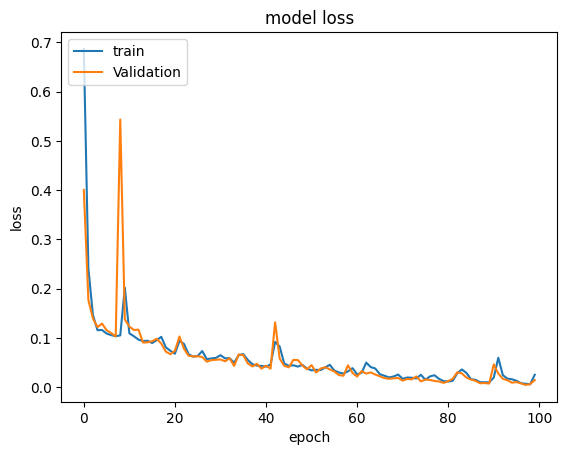

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

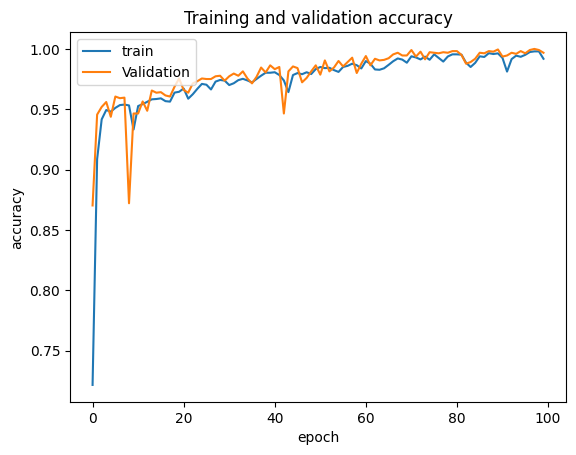

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 4ms/step
[[467   6  23   0   0   0]
 [ 13 449   9   0   0   0]
 [  0   0 420   0   0   0]
 [  3   5   0 400  78   5]
 [  4   2   0  27 499   0]
 [  0   0   0   0   0 537]]
0.9406175771971497
0.9400557706964978
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.97      0.95      0.96       471
           2       0.93      1.00      0.96       420
           3       0.94      0.81      0.87       491
           4       0.86      0.94      0.90       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

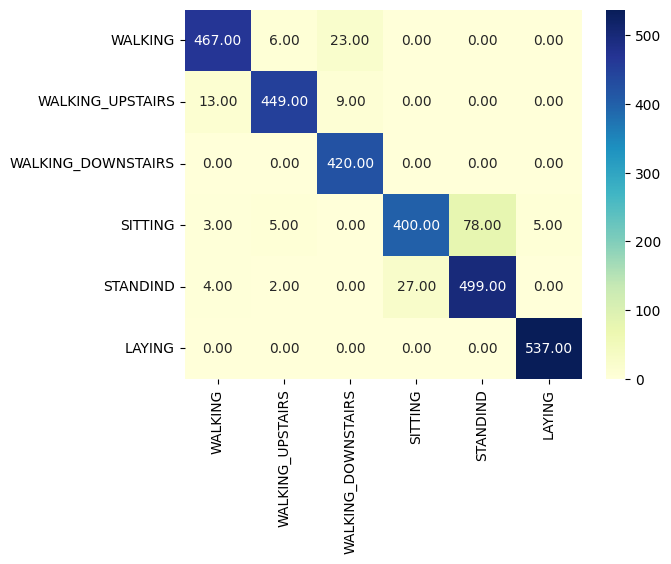

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM2-CNN1</h1>

In [21]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_5 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 dropout_6 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 63, 64)           

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 7s 40ms/step - loss: 0.8327 - accuracy: 0.6503 - val_loss: 0.5232 - val_accuracy: 0.8241
Epoch 2/100
58/58 [==============================] - 1s 23ms/step - loss: 0.3340 - accuracy: 0.8758 - val_loss: 0.2461 - val_accuracy: 0.9175
Epoch 3/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1907 - accuracy: 0.9249 - val_loss: 0.1651 - val_accuracy: 0.9379
Epoch 4/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1443 - accuracy: 0.9433 - val_loss: 0.1576 - val_accuracy: 0.9429
Epoch 5/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1242 - accuracy: 0.9461 - val_loss: 0.1294 - val_accuracy: 0.9483
Epoch 6/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1233 - accuracy: 0.9495 - val_loss: 0.1154 - val_accuracy: 0.9583
Epoch 7/100
58/58 [==============================] - 1s 24ms/step - loss: 0.1191 - accuracy: 0.9510 - val_loss: 0.1309 - val_accuracy: 0.9492
Epoch 

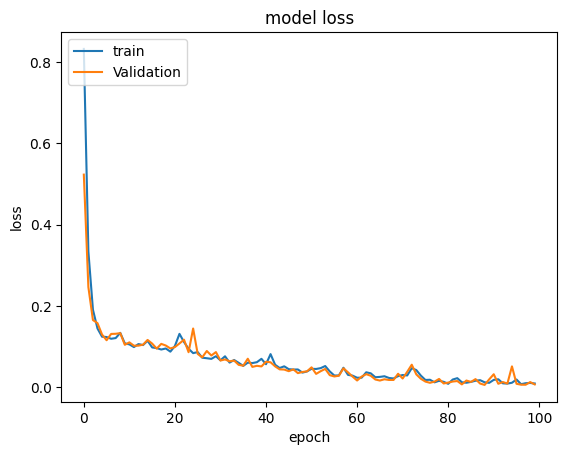

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

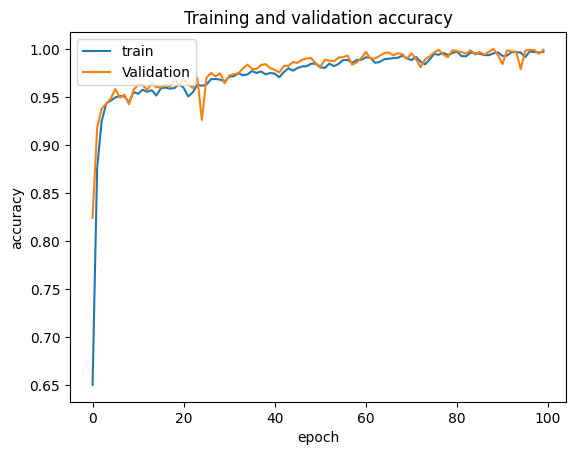

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[470   0  26   0   0   0]
 [  5 465   1   0   0   0]
 [  8   4 408   0   0   0]
 [  0  12   0 416  58   5]
 [  1   0   0  20 511   0]
 [  0   0   0   0   0 537]]
0.9524940617577197
0.9520643152631277
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.97      0.99      0.98       471
           2       0.94      0.97      0.95       420
           3       0.95      0.85      0.90       491
           4       0.90      0.96      0.93       532
           5       0.99      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

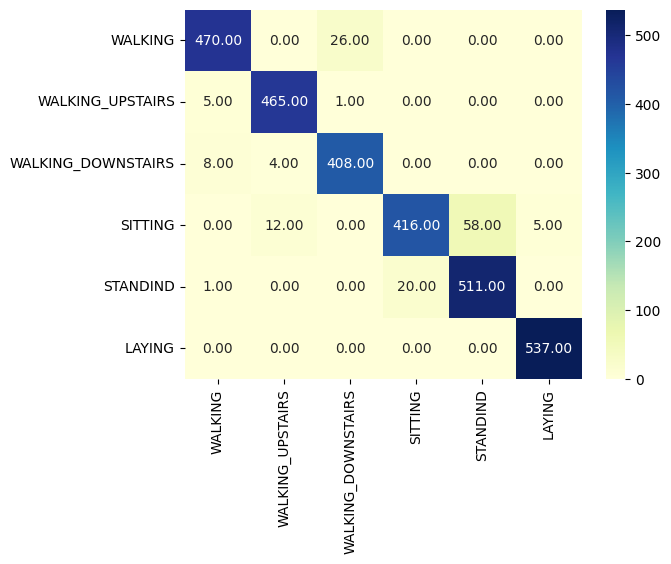

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM2-CNN2</h1>

In [26]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_9 (Dropout)         (None, 124, 64)          

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 7s 45ms/step - loss: 0.9132 - accuracy: 0.6204 - val_loss: 0.5461 - val_accuracy: 0.8046
Epoch 2/100
58/58 [==============================] - 1s 25ms/step - loss: 0.3709 - accuracy: 0.8606 - val_loss: 0.2770 - val_accuracy: 0.9148
Epoch 3/100
58/58 [==============================] - 1s 24ms/step - loss: 0.2081 - accuracy: 0.9214 - val_loss: 0.1608 - val_accuracy: 0.9415
Epoch 4/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1341 - accuracy: 0.9440 - val_loss: 0.1325 - val_accuracy: 0.9578
Epoch 5/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1314 - accuracy: 0.9452 - val_loss: 0.1328 - val_accuracy: 0.9551
Epoch 6/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1150 - accuracy: 0.9520 - val_loss: 0.1146 - val_accuracy: 0.9587
Epoch 7/100
58/58 [==============================] - 2s 26ms/step - loss: 0.1184 - accuracy: 0.9502 - val_loss: 0.1415 - val_accuracy: 0.9506
Epoch 

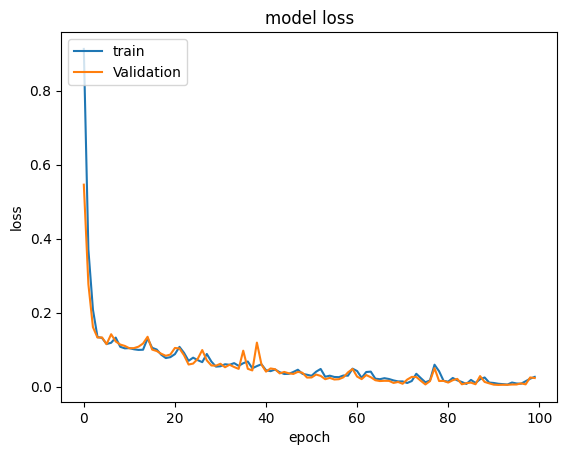

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

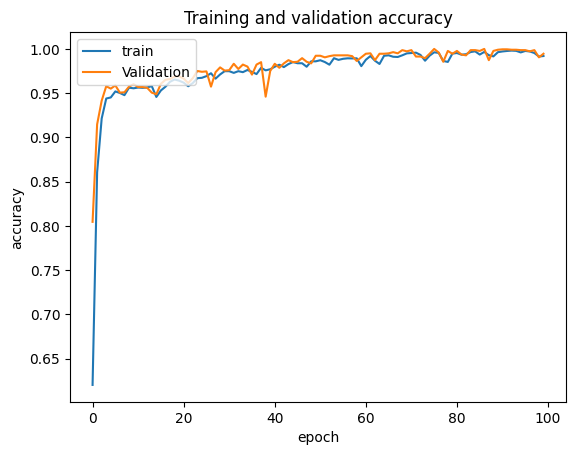

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[457   1  37   1   0   0]
 [ 14 425  28   4   0   0]
 [  0   0 420   0   0   0]
 [  0   4   0 396  86   5]
 [  1   0   0  39 492   0]
 [  0   0   0   0   0 537]]
0.9253478113335596
0.92511695091492
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       496
           1       0.99      0.90      0.94       471
           2       0.87      1.00      0.93       420
           3       0.90      0.81      0.85       491
           4       0.85      0.92      0.89       532
           5       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.92      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

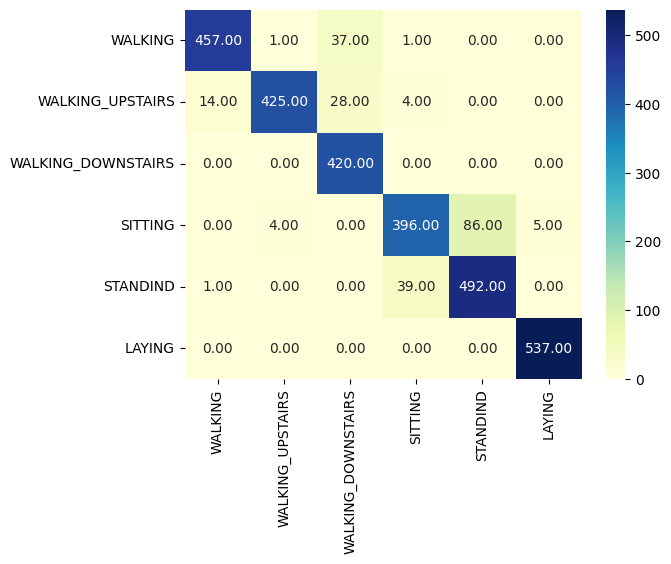

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')